In [1]:
import pandas as pd

# 1. 读取数据集
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
train

gender    age hypertension heart_disease ever_married      work_type  \
0     Female  24.00           No            No          Yes        Private   
1     Female  41.00           No            No          Yes        Private   
2       Male  52.00           No            No          Yes        Private   
3     Female  55.00           No            No          Yes        Private   
4     Female  55.00           No            No          Yes        Private   
...      ...    ...          ...           ...          ...            ...   
3826    Male  61.00           No            No          Yes       Govt_job   
3827  Female  61.00          Yes            No          Yes        Private   
3828  Female   1.16           No            No           No       children   
3829    Male  38.00           No            No          Yes  Self-employed   
3830  Female  46.00           No            No          Yes        Private   

     Residence_type  avg_glucose_level   bmi   smoking_status stroke  
0             Rural             105.26  26.1  formerly smoked     No  
1             Urban              83.97  28.5          Unknown     No  
2             Urban              87.51  30.5  formerly smoked     No  
3             Rural              63.47  27.8          Unknown     No  
4             Rural             111.19  39.7  formerly smoked     No  
...             ...                ...   ...              ...    ...  
3826          Rural             144.14  29.8     never smoked     No  
3827          Rural             170.05  60.2           smokes     No  
3828          Urban              97.28  17.8          Unknown     No  
3829          Rural              93.93  21.5  formerly smoked     No  
3830          Rural             100.15  50.3           smokes     No  

[3831 rows x 11 columns]

In [2]:
# 2. 处理缺失值
from sklearn.impute import SimpleImputer
num_features = train.select_dtypes(include=['float64', 'int64']).columns  # 自动识别数值型特征
cat_features = train.select_dtypes(include=['object']).columns  # 自动识别类别型特征

# 使用 SimpleImputer 填充缺失值
num_imputer = SimpleImputer(strategy='mean')  # 数值型特征使用均值填充
train[num_features] = num_imputer.fit_transform(train[num_features])
test[num_features] = num_imputer.transform(test[num_features])

cat_imputer = SimpleImputer(strategy='most_frequent')  # 类别型特征使用众数填充
train[cat_features] = cat_imputer.fit_transform(train[cat_features])
test[cat_features] = cat_imputer.transform(test[cat_features])

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

catagory = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']

for col in catagory:
    train[col] = label_encoder.fit_transform(train[col])
    test[col]  = label_encoder.transform(     test[col])

# 2. 对类别变量进行标签编码或独热编码
X = train.drop('stroke', axis=1)  # 特征数据
y = train['stroke']  # 标签数据


# 3. 定义决策树模型
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# 4. 定义超参数空间
param_dist = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [None, 10, 20, 50, 100],
    'min_impurity_decrease': [0.0, 0.01, 0.1, 0.2],
    'splitter': ['best', 'random'],
    # 'class_weight': [None, 'balanced'],
    # 'random_state': [42]  # 设定一个种子以确保可重复性
}
# 5. 使用RandomizedSearchCV进行超参数优化，基于交叉验证
random_search = RandomizedSearchCV(estimator=dt, param_distributions=param_dist, 
                                   n_iter = 10000, cv = 5, verbose=  10, random_state=42, n_jobs=-1)
random_search.fit(X, y)

# 6. 获取最好的模型
best_model = random_search.best_estimator_

# 7. 在测试集上评估
y_test_pred = best_model.predict(test.drop('stroke', axis=1))
print("Test Accuracy:", accuracy_score(test['stroke'], y_test_pred))
print("Test Classification Report:")
print(classification_report(test['stroke'], y_test_pred))

# 8. 保存最佳模型
joblib.dump(best_model, 'best_decision_tree_model.pkl')


Fitting 5 folds for each of 10000 candidates, totalling 50000 fits
Test Accuracy: 0.9147104851330203
Test Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1198
           1       0.24      0.16      0.19        80

    accuracy                           0.91      1278
   macro avg       0.59      0.56      0.57      1278
weighted avg       0.90      0.91      0.91      1278



['best_decision_tree_model.pkl']

In [7]:
from sklearn import metrics

accuracy = metrics.accuracy_score(test['stroke'], y_test_pred)
print(f'Accuracy: {accuracy:.4f}')
auc = metrics.roc_auc_score(test['stroke'], y_test_pred)
print(f'AUC: {auc:.4f}')

Accuracy: 0.9147
AUC: 0.5637


In [5]:
import joblib
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# 加载最佳模型
# best_model = joblib.load('best_decision_tree_model.pkl')

# 可视化决策树
plt.figure(figsize=(200, 100))  # 设置图形大小
plot_tree(best_model, filled=True, feature_names=train.columns, class_names=['No Stroke', 'Stroke'], rounded=True, fontsize=12)
plt.show()


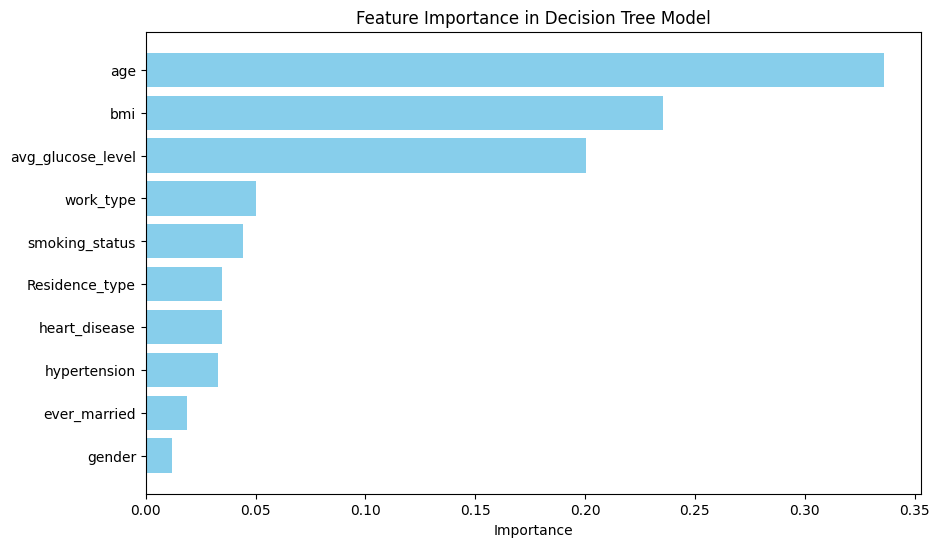

In [6]:

# 获取特征重要性
feature_importance = best_model.feature_importances_

# 创建一个包含特征名称和对应重要性的 DataFrame
feature_df = pd.DataFrame({
    'Feature': test.columns[:-1],
    'Importance': feature_importance
})

# 按重要性降序排序
feature_df = feature_df.sort_values(by='Importance', ascending=False)
import matplotlib.pyplot as plt

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Decision Tree Model')
plt.gca().invert_yaxis()  # 倒序显示特征（最重要的在上面）
plt.show()
